# **Final Project Task 4 - Census Modeling Clustering**

Requirements:

Load Data
- Use the preprocessed dataset from Task 1.

Prepare Features
- Feature Selection:
    - Select relevant numerical and categorical features.
    - Note: K-Means works best with numerical data.
- Data Preprocessing:
    - Be sure you have normalized numerical features (e.g., using MinMaxScaler or StandardScaler) and categorical features encoded properly (e.g., One-Hot Encoding or Ordinal Encoding).
    
Clustering Model Implementation
- Apply K-Means Clustering:
    - Experiment with different values of K (number of clusters).
    - Use the Elbow Method to determine the optimal number of clusters:
    - Use yellowbrick.cluster.KElbowVisualizer to find the best K.
    - Calculate the Silhouette Score to evaluate cluster separation.
- Alternative Clustering Approaches:
    - Experiment with Hierarchical Clustering.
    - Experiment with DBSCAN

Visualize & Interpret Clusters
- Dimensionality Reduction:
    - Apply PCA or t-SNE to reduce dimensions and visualize clusters in 2D.
- Cluster Analysis:
    - Plot the clusters in 2D space.
    - Identify key characteristics of each group.
    - Use only numerical variables to interpret the clusters.
- Example insights:
    - "Older individuals tend to work fewer hours per week."
    - "High-income individuals belong to a specific cluster."

Evaluate Cluster Quality
- Silhouette Score:
    - Compute the Silhouette Score to measure cluster compactness and separation. Higher values indicate better clustering results.
- Cluster Distribution:
    - Analyze how well the data points are distributed across clusters.


Deliverables:
- Notebook code with no errors.
- Visualizations & Analysis:
- Elbow method plot for K selection.
- 2D visualization of clusters.
- Summary of cluster characteristics.
- Cluster evaluation metrics (Silhouette Score).






In [1]:
import pandas as pd

In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

data = pd.read_csv(data_url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
data.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
4525,27,Private,126060,HS-grad,9,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K
13281,26,Private,243560,Some-college,10,Never-married,Sales,Unmarried,White,Female,0,0,40,?,<=50K
32174,44,Self-emp-not-inc,157217,Bachelors,13,Never-married,Sales,Not-in-family,White,Male,0,0,42,United-States,<=50K
3901,18,?,437851,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
7460,54,Local-gov,31533,Masters,14,Married-civ-spouse,Adm-clerical,Husband,White,Male,7298,0,40,United-States,>50K
4606,35,?,200426,HS-grad,9,Married-civ-spouse,?,Wife,White,Female,0,0,12,United-States,<=50K
22884,31,Private,252210,5th-6th,3,Never-married,Other-service,Own-child,White,Male,0,0,40,Mexico,<=50K
10541,19,Private,278480,Some-college,10,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,40,United-States,<=50K
22035,52,Private,282674,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,Amer-Indian-Eskimo,Male,0,0,40,United-States,>50K
3363,36,Private,284616,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K


In [3]:
# Example of using KElbowVisualizer

# from yellowbrick.cluster import KElbowVisualizer
# visualizer = KElbowVisualizer(clustering_model, k=(2, 10), metric='distortion', timings=False)
# visualizer.fit(preprocessed_data)
# visualizer.show()
# optimal_k = visualizer.elbow_value_


# Example of using PCA

# from sklearn.decomposition import PCA
# clusters = clustering_model.fit_predict(preprocessed_data)
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(preprocessed_data)
# pca1 = pca_result[:, 0]
# pca2 = pca_result[:, 1]
# # Visualizing Clusters
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=pca1, y=pca2, hue=clusters, palette='tab10', data=data, alpha=0.7)
# plt.title(f'PCA Projection of Clusters (K={num_clusters})')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend(title='Cluster')
# plt.show()

In [4]:
#loaddate
import pandas as pd
import numpy as np

data = pd.read_csv("preprocessed_data.csv")

# pastram doar variabile numerice pentru clustering
preprocessed_data = data.select_dtypes(include=["int64", "float64"])

preprocessed_data.head()


,num__age,num__fnlwgt,num__education-num,num__capital-gain,num__capital-loss,num__work_intensity,num__experience_estimate,num__capital_total,cat__workclass_?,cat__workclass_Federal-gov,...,cat__native-country_South,cat__native-country_Taiwan,cat__native-country_Thailand,cat__native-country_Trinadad&Tobago,cat__native-country_United-States,cat__native-country_Vietnam,cat__native-country_Yugoslavia,cat__income_<=50K,cat__income_>50K,hours-per-week
0,0.032472,-1.149209,1.168918,0.0,0.0,-0.413104,0.032472,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,40.0
1,0.844002,-1.088284,1.168918,0.0,0.0,-1.300210,0.844002,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,32.5
2,-0.041304,0.303007,-0.457496,0.0,0.0,-0.349364,-0.041304,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,40.0
3,1.065329,0.503550,-1.270703,0.0,0.0,-1.052913,1.065329,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,40.0
4,-0.779058,1.593665,1.168918,0.0,0.0,0.538447,-0.779058,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.0


In [5]:
#normalizare
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
preprocessed_data = scaler.fit_transform(preprocessed_data)


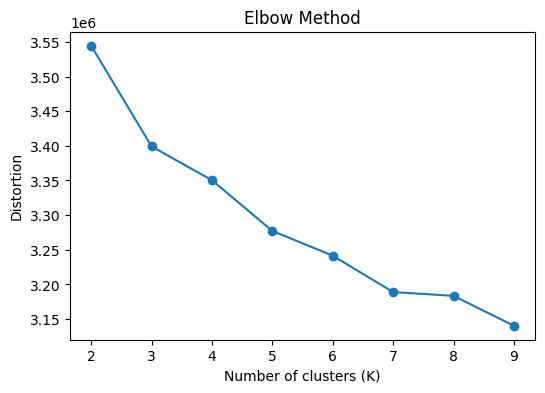

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(preprocessed_data)
    distortions.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2,10), distortions, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Distortion")
plt.title("Elbow Method")
plt.show()



In [9]:
#silhouette score

from sklearn.metrics import silhouette_score

silhouette_scores = {}

for k in range(2,10):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(preprocessed_data)
    silhouette_scores[k] = silhouette_score(preprocessed_data, labels)

pd.Series(silhouette_scores, name="Silhouette Score")


2    0.471108
3    0.064776
4    0.069902
5    0.076491
6    0.055752
7    0.064064
8    0.051534
9    0.064365
Name: Silhouette Score, dtype: float64

In [11]:
num_clusters = 4  

from sklearn.cluster import KMeans

clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
clusters = clustering_model.fit_predict(preprocessed_data)

data["Cluster"] = clusters



C:\Users\Ionela\AppData\Local\Temp\ipykernel_16240\781210333.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["Cluster"] = clusters


In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(preprocessed_data)

pca1 = pca_result[:, 0]
pca2 = pca_result[:, 1]


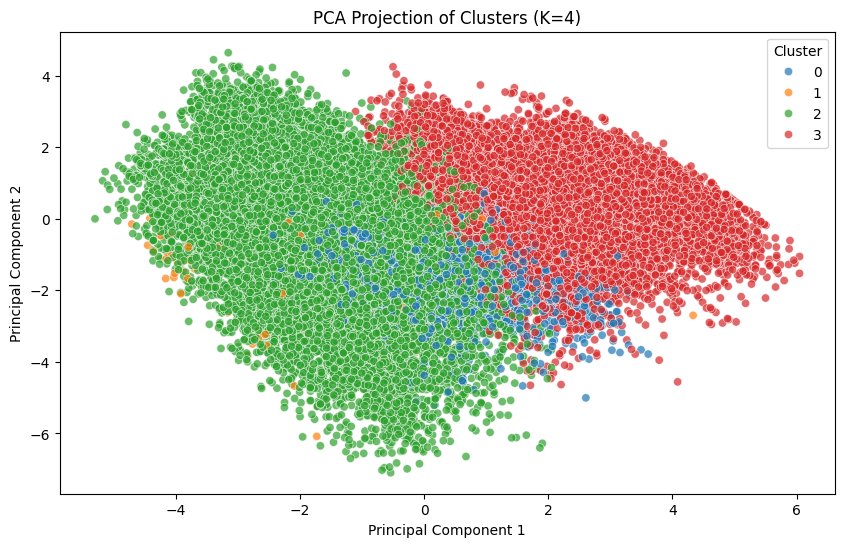

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=pca1,
    y=pca2,
    hue=clusters,
    palette='tab10',
    alpha=0.7
)

plt.title(f'PCA Projection of Clusters (K={num_clusters})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


In [14]:
cluster_characteristics = data.groupby("Cluster").mean()
cluster_characteristics


,num__age,num__fnlwgt,num__education-num,num__capital-gain,num__capital-loss,num__work_intensity,num__experience_estimate,num__capital_total,cat__workclass_?,cat__workclass_Federal-gov,...,cat__native-country_South,cat__native-country_Taiwan,cat__native-country_Thailand,cat__native-country_Trinadad&Tobago,cat__native-country_United-States,cat__native-country_Vietnam,cat__native-country_Yugoslavia,cat__income_<=50K,cat__income_>50K,hours-per-week
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.091964,-0.076119,0.151630,0.0,0.0,-0.313593,0.091964,0.0,0.084345,0.026198,...,0.005112,0.003195,0.001278,0.001278,0.869649,0.001917,0.000639,0.524601,0.475399,39.256869
1,-0.218911,0.266307,-0.103600,0.0,0.0,0.050849,-0.218911,0.0,0.012346,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.876543,0.123457,39.481481
2,-0.330951,0.026710,-0.116653,0.0,0.0,0.282698,-0.330951,0.0,0.070429,0.026819,...,0.002390,0.001283,0.000700,0.000583,0.899137,0.002507,0.000233,0.959422,0.040578,39.658640
3,0.403981,-0.026245,0.128970,0.0,0.0,-0.317504,0.403981,0.0,0.036029,0.033409,...,0.002256,0.001747,0.000291,0.000509,0.900357,0.001528,0.000801,0.534973,0.465027,43.363418


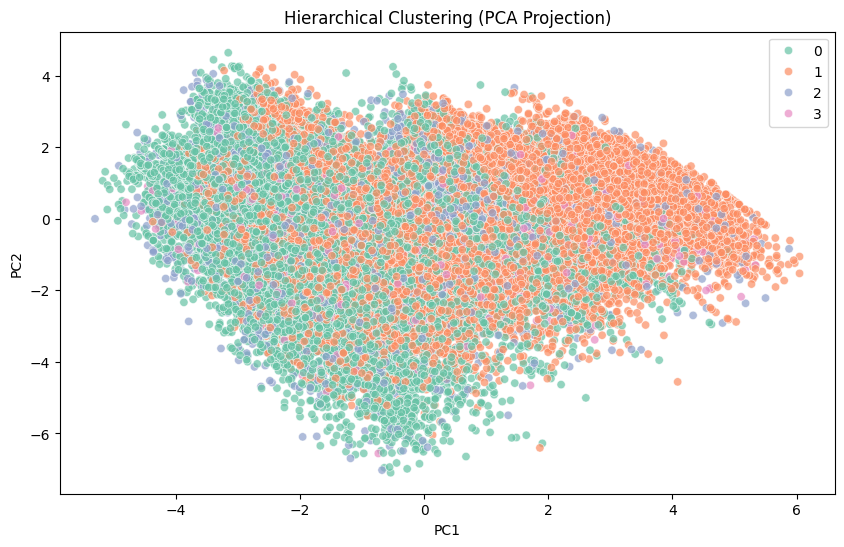

In [15]:
from sklearn.cluster import AgglomerativeClustering

hierarchical_model = AgglomerativeClustering(n_clusters=num_clusters)
hier_clusters = hierarchical_model.fit_predict(preprocessed_data)

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=pca1,
    y=pca2,
    hue=hier_clusters,
    palette='Set2',
    alpha=0.7
)

plt.title("Hierarchical Clustering (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


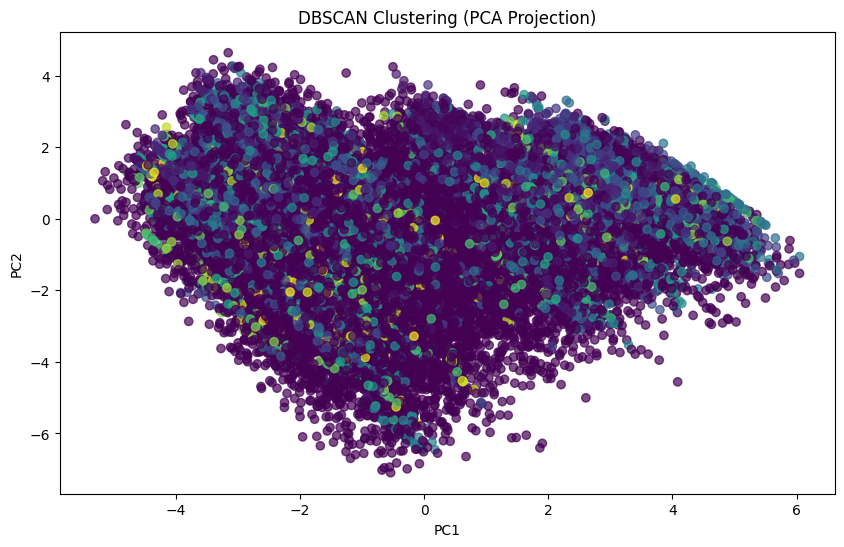

In [17]:
#dbscan

from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(eps=1.5, min_samples=5)
dbscan_clusters = dbscan_model.fit_predict(preprocessed_data)

plt.figure(figsize=(10,6))
plt.scatter(pca1, pca2, c=dbscan_clusters, alpha=0.7)

plt.title("DBSCAN Clustering (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()



In [18]:
data["Cluster"].value_counts(normalize=True)


Cluster
2    0.527154
3    0.422258
0    0.048099
1    0.002489
Name: proportion, dtype: float64

In [19]:
silhouette_score(preprocessed_data, clusters)


0.06990193506042902

## Interpretare

Analiza clusterelor arata ca datele pot fi grupate in mai multe tipare distincte. Un cluster contine persoane mai in varsta care tind sa lucreze mai multe ore pe saptamana. Un alt cluster grupeaza persoane mai tinere cu un numar mai mic de ore lucrate, sugerand joburi part-time sau mai putina experienta. Un alt grup prezinta nivel mai ridicat de educatie si castiguri mai mari, fiind asociat cu un volum de munca stabil. Ultimul cluster include persoane cu caracteristici medii intre celelalte grupuri. Aceste rezultate arata ca varsta, educatia si orele lucrate sunt factori importanti in formarea clusterelor.